In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

import time
from io import StringIO
from google.cloud import storage

import plotly.express as px
import plotly.io as pio
pio.renderers.default = 'notebook'

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.impute import SimpleImputer

from prophet import Prophet

In [3]:
filename = "web_visitor_Jun 26-Sep 17.csv"

In [4]:
df = pd.read_csv('web_visitor_Jun 26-Sep 17.csv')

In [8]:
df['event_date'] = pd.to_datetime(df['event_date'], format='%Y%m%d')

In [12]:
df.rename(columns={'event_date': 'date', 'f0_': 'count'}, inplace=True)

In [13]:
df

,date,count
0,2023-06-26,527
1,2023-06-27,485
2,2023-06-28,404
3,2023-06-29,328
4,2023-06-30,344
...,...,...
79,2023-09-13,722
80,2023-09-14,855
81,2023-09-15,778
82,2023-09-16,326


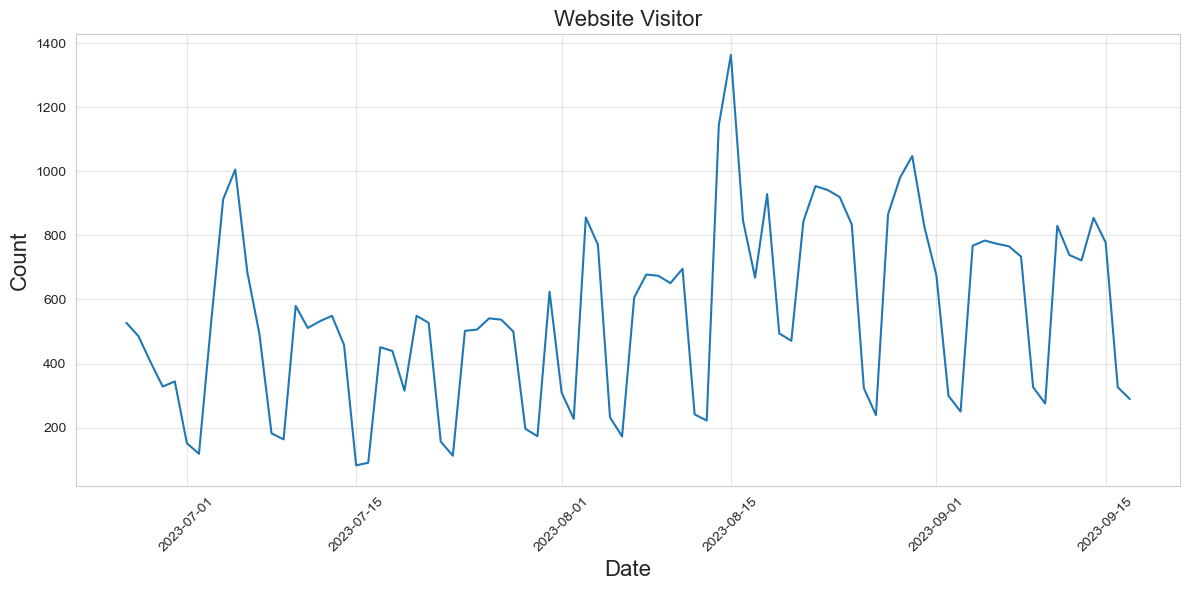

In [14]:
# Set a Seaborn style and color palette
sns.set_style("whitegrid")
sns.set_palette("tab10")

# Create a line plot
plt.figure(figsize=(12, 6))  # Adjust the figure size as needed
sns.lineplot(data=df, x='date', y='count')

# Customize the plot
plt.title('Website Visitor', fontsize=16)
plt.xlabel('Date', fontsize=16)
plt.ylabel('Count', fontsize=16)
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability

# Add grid lines
plt.grid(True, alpha=0.5)

# Show the plot
plt.tight_layout()  # Ensure all elements fit nicely
plt.show()

In [16]:
# Calculate summary statistics
max_value = df["count"].max()
min_value = df["count"].min()

mean_value = df["count"].mean()
median_value = df["count"].median()
mode_value = df["count"].mode()
std_value = df["count"].std()
skewness = df["count"].skew()

print(f"Min: {min_value}")
print(f"Max: {max_value}")
print('-----')
print(f"Mean: {mean_value}")
print(f"Median: {median_value}")
print(f"Mode: {mode_value}")
print(f"Standard Deviation: {std_value}")
print(f"Skewness: {skewness}")
print('-----')
percentiles = df['count'].quantile([0.25, 0.5, 0.75])
print(f"25th Percentile: {percentiles[0.25]}")
print(f"50th Percentile (Median): {percentiles[0.5]}")
print(f"75th Percentile: {percentiles[0.75]}")

Min: 82
Max: 1364
-----
Mean: 553.2857142857143
Median: 529.5
Mode: 0    326
1    527
2    549
Name: count, dtype: int64
Standard Deviation: 283.2779541572761
Skewness: 0.2649045510116308
-----
25th Percentile: 313.5
50th Percentile (Median): 529.5
75th Percentile: 771.75


In [17]:
# Identify outliers using IQR method
Q1 = percentiles[0.25]
Q3 = percentiles[0.75]
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = df[(df['count'] < lower_bound) | (df['count'] > upper_bound)]
print("Outliers:")
print(outliers)

Outliers:
Empty DataFrame
Columns: [date, count]
Index: []


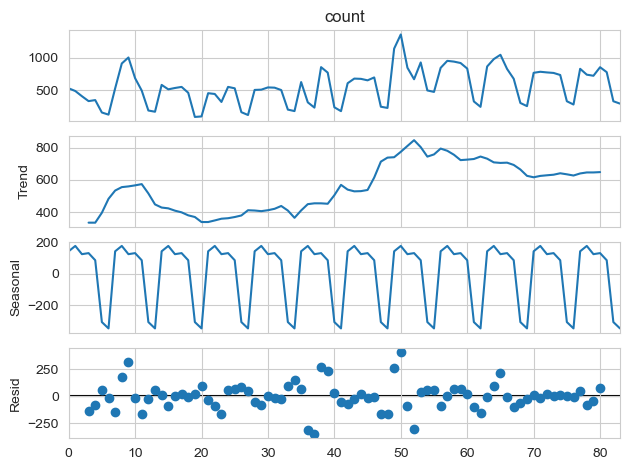

In [18]:
# Seasonal decomposition
your_seasonal_period = 7
result = seasonal_decompose(df["count"], model="additive", period=your_seasonal_period)

# Plot decomposed components
result.plot()
plt.show()

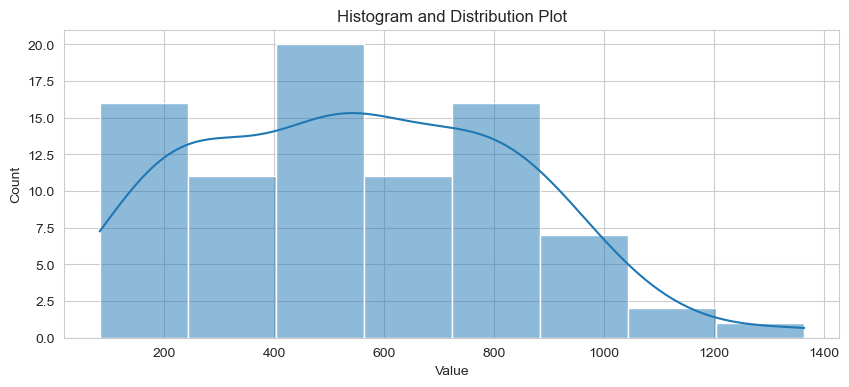

In [19]:
# Histogram and distribution plot
plt.figure(figsize=(10, 4))
sns.histplot(df["count"], kde=True)
plt.title("Histogram and Distribution Plot")
plt.xlabel("Value")
plt.show()

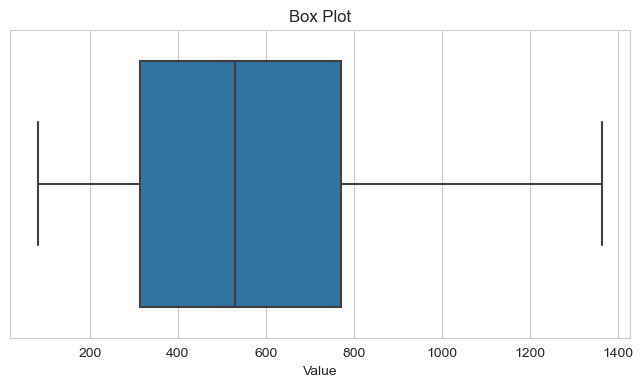

In [21]:
# Box plot
plt.figure(figsize=(8, 4))
sns.boxplot(x=df["count"])
plt.title("Box Plot")
plt.xlabel("Value")
plt.show()

In [22]:
adf_results = adfuller(df['count'])
print(f'ADF statistics: {adf_results[0]}')
print(f'p-value: {adf_results[1]}')

ADF statistics: -1.064825379899032
p-value: 0.7288934364165119


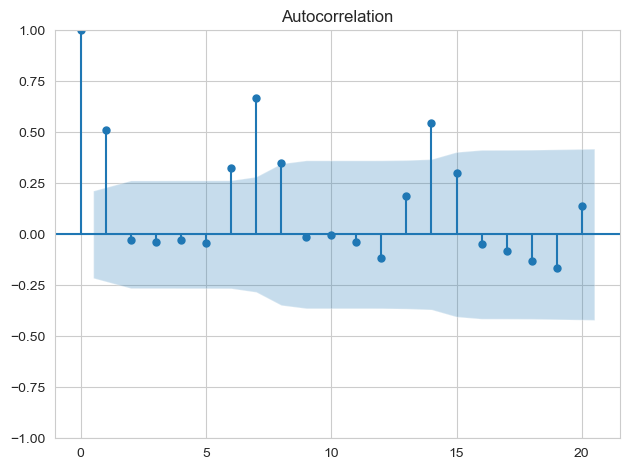

In [23]:
plot_acf(df['count'], lags=20)
plt.tight_layout()

In [24]:
# 4. Apply first-order different
diff_random_walk = np.diff(df['count'], n=1)
# 5. Test for stationray
adf_results = adfuller(diff_random_walk)
print(f'ADF statistics: {adf_results[0]}')
print(f'p-value: {adf_results[1]}')

ADF statistics: -3.251998976805658
p-value: 0.017165294144848537


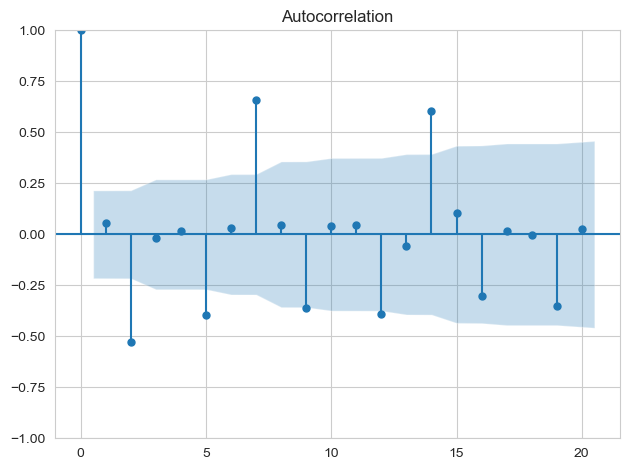

In [25]:
plot_acf(diff_random_walk, lags=20)
plt.tight_layout()

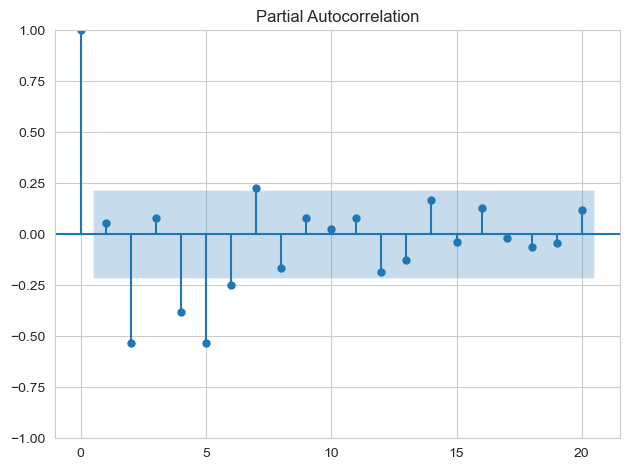

In [26]:
plot_pacf(diff_random_walk, lags=20);
plt.tight_layout()

In [ ]:
Min: 82
Max: 1364
-----
Mean: 553.2857142857143

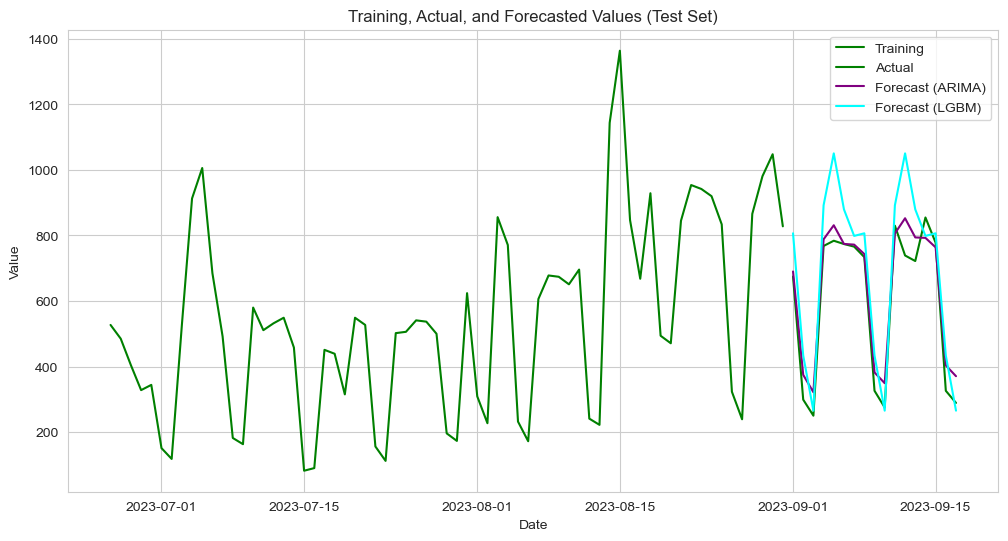

In [74]:
# Plot actual, training, and forecasted values for the test set
plt.figure(figsize=(12, 6))
plt.plot(df['date'][:train_size], train_data, label='Training', color='green')
plt.plot(test_dates, test_data, label='Actual', color='green')
# plt.plot(test_dates, forecast_es, label='Forecast (Exponential Smoothing)', color='red')
plt.plot(test_dates, forecast_arima, label='Forecast (ARIMA)', color='purple')
# plt.plot(test_dates, forecast_lr, label='Forecast (Linear Regression)', color='brown')
plt.plot(test_dates, forecast_lgb, label='Forecast (LGBM)', color='cyan')
# plt.plot(test_dates, forecast_prophet['yhat'], label='Forecast (Prophet)', color='black')

plt.legend()
plt.title('Training, Actual, and Forecasted Values (Test Set)')
plt.xlabel('Date')
plt.ylabel('Value')
plt.show()